In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import max_drawdown
from calendar import monthrange
import warnings


warnings.filterwarnings("ignore")
#Annual rebalancing
def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

tickers = ['SIM', 'ASR', 'PAC', 'OMAB', 'KOF', 'FMX', 'AMX', 'CX', 'VLRS']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_annual_w = []
cash_annual_m = []
cash_annual_l = []

for year in range(2014, 2024):
    sorted_returns = final_df.loc[year].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_year = year + 1
    if next_year in final_df.index:
        returns_next_year_w = final_df.loc[next_year][last_three.index]
        total_return_w = ((cash_w / 3) * (1 + returns_next_year_w)).sum()
        cash_w = total_return_w
        cash_annual_w.append((year + 1, cash_w))
        returns_next_year_m = final_df.loc[next_year][middle_three.index]
        total_return_m = ((cash_m / 3) * (1 + returns_next_year_m)).sum()
        cash_m = total_return_m
        cash_annual_m.append((year + 1, cash_m))
        returns_next_year_l = final_df.loc[next_year][first_three.index]
        total_return_l = ((cash_l / 3) * (1 + returns_next_year_l)).sum()
        cash_l = total_return_l
        cash_annual_l.append((year + 1, cash_l))

years_w, cash_values_w = zip(*cash_annual_w)
years_m, cash_values_m = zip(*cash_annual_m)
years_l, cash_values_l = zip(*cash_annual_l)

years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in range(2014, 2025):
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for year in range(2014, 2025):
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[year].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_year = selected_returns[selected_returns.index.year == year+1]
        avg_daily_returns = selected_returns_year.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_a = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_a_maxdd=max_drawdowns_values_a["top"]
m_a_maxdd=max_drawdowns_values_a["middle"]
l_a_maxdd=max_drawdowns_values_a["bottom"]

df2=pd.DataFrame()
df2=df1
df2.head(10)
#df1.to_csv("annual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,121.899322,76.363602,113.934659,21.899322,-23.636398,13.934659,22.719508,25.995987,22.566189,0.963899,-0.909233,0.617502,-12.995851,-30.283107,-13.365240
2016,113.014542,71.237939,173.326891,-7.288621,-6.712181,52.128327,28.456993,25.474254,34.989110,-0.256128,-0.263489,1.489844,-27.426202,-19.840042,-23.034063
2017,109.732225,87.308224,183.489876,-2.904332,22.558604,5.863479,20.639121,20.189646,17.204374,-0.140720,1.117335,0.340813,-20.264398,-23.992524,-22.065572
2018,92.690121,80.738171,142.907225,-15.530628,-7.525125,-22.117106,27.694090,25.364179,28.487480,-0.560792,-0.296683,-0.776380,-33.778348,-22.669780,-28.981361
2019,117.595182,93.188885,204.173594,26.869165,15.421100,42.871429,19.967175,18.969548,25.191764,1.345667,0.812940,1.701803,-10.825696,-15.171289,-21.367474
2020,117.298030,81.864000,239.606447,-0.252691,-12.152614,17.354278,65.281702,42.611563,44.749088,-0.003871,-0.285195,0.387813,-69.525823,-46.330337,-45.965764
2021,190.321791,110.275718,269.069751,62.254891,34.705998,12.296541,36.249384,22.873500,19.655135,1.717405,1.517302,0.625615,-24.853642,-12.976529,-13.733066
2022,164.949155,105.314743,325.426175,-13.331440,-4.498701,20.944912,30.190218,33.331599,23.110599,-0.441581,-0.134968,0.906290,-34.094267,-24.207390,-17.450539
2023,209.652945,151.256686,442.748724,27.101558,43.623468,36.051971,27.300684,31.902366,30.183004,0.992706,1.367405,1.194446,-22.755759,-27.381044,-37.406891


In [2]:
#Semi-Annual Rebalancing
import pandas as pd
import matplotlib.pyplot as plt

#returns calculation
def semi_annual_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-06-30"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        half_year_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-01"] = half_year_return_1
        
        start_date_2 = f"{year}-06-30"
        end_date_2 = f"{year}-12-31"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        half_year_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-02"] = half_year_return_2
    
    return pd.Series(returns)

tickers = ['SIM', 'ASR', 'PAC', 'OMAB', 'KOF', 'FMX', 'AMX', 'CX', 'VLRS']
data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

semi_annual_returns_dict = {key: semi_annual_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(semi_annual_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_semi_annual_w = []
cash_semi_annual_m = []
cash_semi_annual_l = []

#cash calculation
for period in final_df.index[1:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_semi_annual_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_semi_annual_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_semi_annual_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_semi_annual_w)
periods_m, cash_values_m = zip(*cash_semi_annual_m)
periods_l, cash_values_l = zip(*cash_semi_annual_l)
cash_values_w=cash_values_w[1::2]
cash_values_m=cash_values_m[1::2]
cash_values_l=cash_values_l[1::2]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])


# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    year, half = int(date[:4]), int(date[-1])
    
    if half == 1:
        current_date = pd.Timestamp(year=year, month=1, day=1)
        next_half_start = pd.Timestamp(year=year, month=7, day=1)
        next_half_end = pd.Timestamp(year=year, month=12, day=31)
    else:
        current_date = pd.Timestamp(year=year, month=7, day=1)
        next_half_start = pd.Timestamp(year=year+1, month=1, day=1)
        next_half_end = pd.Timestamp(year=year+1, month=6, day=30)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        
        # Ensure that the end date does not exceed the dataset's available date range
        next_half_end = min(next_half_end, daily_returns_df.index[-1])
        
        # Select returns for the calculated period
        selected_returns_period = selected_returns.loc[next_half_start:next_half_end]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        
        # average daily returns concatenation
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_sa = {group: round(float(value), 2) if isinstance(value, (float, np.float64)) else round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_sa_maxdd = max_drawdowns_values_sa["top"]
m_sa_maxdd = max_drawdowns_values_sa["middle"]
l_sa_maxdd = max_drawdowns_values_sa["bottom"]

df3=pd.DataFrame()
df3=df1
df3.head(10)
#df1.to_csv("semiannual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,132.227737,104.378135,69.503911,32.227737,4.378135,-30.496089,23.845496,21.103416,27.458926,1.351523,0.207461,-1.110607,-13.468715,-16.422883,-34.196177
2016,112.166495,172.912905,65.228704,-15.171735,65.660084,-6.151032,27.296534,28.998800,32.527990,-0.555812,2.264235,-0.189100,-26.871575,-15.516839,-30.386380
2017,108.128899,231.003673,60.556632,-3.599645,33.595392,-7.162601,20.403384,19.859546,19.682501,-0.176424,1.691650,-0.363907,-24.275552,-14.608404,-32.007337
2018,95.077108,216.510301,44.935511,-12.070586,-6.274087,-25.795887,24.530029,26.378253,29.831093,-0.492074,-0.237851,-0.864732,-27.770746,-31.120873,-33.699438
2019,135.239632,267.269036,52.958032,42.242055,23.444028,17.853408,23.873245,18.090021,24.271223,1.769431,1.295965,0.735579,-17.401788,-14.486762,-18.252404
2020,113.750017,267.945212,68.239081,-15.890028,0.252995,28.855018,49.399926,55.252996,49.179492,-0.321661,0.004579,0.586729,-56.645160,-59.511253,-48.516339
2021,183.647366,287.675089,97.044185,61.448210,7.363400,42.212033,36.249384,25.413949,18.885575,1.695152,0.289739,2.235147,-24.853642,-13.880338,-11.625728
2022,207.179785,345.527727,66.013750,12.813916,20.110410,-31.975573,26.642382,22.645640,38.024912,0.480960,0.888048,-0.840911,-13.888622,-13.799549,-47.845160
2023,248.887494,482.072553,96.490418,20.131167,39.517762,46.167151,31.551644,25.539889,29.569957,0.638039,1.547296,1.561286,-39.617277,-23.840205,-22.493566


In [3]:
# Quarterly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt

#returns calculations
def quarterly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-03-31"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        quarter_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-Q1"] = quarter_return_1
        
        start_date_2 = f"{year}-03-31"
        end_date_2 = f"{year}-06-30"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        quarter_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-Q2"] = quarter_return_2
        
        start_date_3 = f"{year}-06-30"
        end_date_3 = f"{year}-09-30"
        start_price_3 = df['Adj Close'].loc[:start_date_3].iloc[-1]
        end_price_3 = df['Adj Close'].loc[:end_date_3].iloc[-1]
        quarter_return_3 = (end_price_3 - start_price_3) / start_price_3
        returns[f"{year}-Q3"] = quarter_return_3
        
        start_date_4 = f"{year}-09-30"
        end_date_4 = f"{year}-12-31"
        start_price_4 = df['Adj Close'].loc[:start_date_4].iloc[-1]
        end_price_4 = df['Adj Close'].loc[:end_date_4].iloc[-1]
        quarter_return_4 = (end_price_4 - start_price_4) / start_price_4
        returns[f"{year}-Q4"] = quarter_return_4
    
    return pd.Series(returns)

tickers = ['SIM', 'ASR', 'PAC', 'OMAB', 'KOF', 'FMX', 'AMX', 'CX', 'VLRS']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}
quarterly_returns_dict = {key: quarterly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(quarterly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_quarterly_w = []
cash_quarterly_m = []
cash_quarterly_l = []

#cash calculations
for period in final_df.index[3:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_quarterly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_quarterly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_quarterly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_quarterly_w)
periods_m, cash_values_m = zip(*cash_quarterly_m)
periods_l, cash_values_l = zip(*cash_quarterly_l)
cash_values_w=cash_values_w[3::4]
cash_values_m=cash_values_m[3::4]
cash_values_l=cash_values_l[3::4]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[3:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

# function to get the start and end date of the next quarter
def get_next_quarter_dates(date_str):
    # Extract the year and quarter from the input string (e.g., '2001Q1')
    year = int(date_str[:4])
    quarter = int(date_str[-1])
    
    # start and end dates for the next quarter
    if quarter == 1:
        start_date = f"{year}-04-01"
        end_date = f"{year}-06-30"
    elif quarter == 2:
        start_date = f"{year}-07-01"
        end_date = f"{year}-09-30"
    elif quarter == 3:
        start_date = f"{year}-10-01"
        end_date = f"{year}-12-31"
    else:  # If it's Q4, the next quarter is Q1 of the next year
        start_date = f"{year+1}-01-01"
        end_date = f"{year+1}-03-31"
    
    return start_date, end_date

for date in final_df.index[3:]:
    # next quarter dates
    start_date, end_date = get_next_quarter_dates(date)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_q = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_quar_maxdd=max_drawdowns_values_q["top"]
m_quar_maxdd=max_drawdowns_values_q["middle"]
l_quar_maxdd=max_drawdowns_values_q["bottom"]
df4=pd.DataFrame()
df4=df1
df4.head(10)
#df1.to_csv("quarterly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,124.285604,110.942603,69.620218,24.285604,10.942603,-30.379782,22.978447,22.312179,27.218932,1.056886,0.490432,-1.116127,-12.616081,-14.242854,-33.179318
2016,137.204908,109.734751,86.210211,10.394852,-1.088718,23.829274,28.752304,28.746435,31.327162,0.361531,-0.037873,0.760659,-26.797752,-19.231077,-22.245832
2017,146.279728,131.001880,79.033903,6.614064,19.380488,-8.324197,21.241741,18.677893,19.342026,0.311371,1.037616,-0.430368,-21.923061,-17.130366,-28.696910
2018,97.749784,124.767247,79.643182,-33.176124,-4.759194,0.770909,29.776127,25.653657,26.379594,-1.114185,-0.185517,0.029224,-41.923765,-21.276197,-24.638833
2019,118.186790,156.711132,104.759454,20.907469,25.602781,31.535997,22.712972,19.232618,24.160536,0.920508,1.331217,1.305269,-17.474394,-14.323202,-20.924000
2020,113.805094,162.826801,115.782852,-3.707433,3.902511,10.522581,51.293719,52.178028,51.955464,-0.072278,0.074792,0.202531,-64.402116,-54.747727,-49.077773
2021,143.986134,192.916329,213.847583,26.519937,18.479468,84.697111,30.473145,21.266798,27.354717,0.870272,0.868935,3.096253,-19.147379,-14.770847,-10.542401
2022,173.787032,179.443172,178.835797,20.697061,-6.983938,-16.372309,24.900676,28.023442,34.448944,0.831185,-0.249218,-0.475263,-14.007518,-29.376808,-33.076697
2023,246.730672,225.928926,254.069025,41.973005,25.905558,42.068327,30.016144,28.753477,30.071753,1.398348,0.900954,1.398932,-36.607249,-27.982888,-21.317325


In [4]:
#Monthly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt
from calendar import monthrange

#return calculation
def monthly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025):
        for month in range(1, 13):
            start_date = pd.Timestamp(year=year, month=month, day=1) - pd.Timedelta(days=1)
            end_date = pd.Timestamp(year=year, month=month, day=monthrange(year, month)[1])
            
            start_price = df['Adj Close'].loc[:start_date].iloc[-1]
            end_price = df['Adj Close'].loc[:end_date].iloc[-1]
            month_return = (end_price - start_price) / start_price
            returns[f"{year}-{month:02d}"] = month_return
    
    return pd.Series(returns)

tickers = ['SIM', 'ASR', 'PAC', 'OMAB', 'KOF', 'FMX', 'AMX', 'CX', 'VLRS']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}

monthly_returns_dict = {key: monthly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(monthly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_monthly_w = []
cash_monthly_m = []
cash_monthly_l = []

#cash calculation
for period in final_df.index[11:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_monthly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_monthly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_monthly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_monthly_w)
periods_m, cash_values_m = zip(*cash_monthly_m)
periods_l, cash_values_l = zip(*cash_monthly_l)
cash_values_w=cash_values_w[11::12]
cash_values_m=cash_values_m[11::12]
cash_values_l=cash_values_l[11::12]
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])

# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    year, month = map(int, date.split('-'))
    
    # Determine the next month and year
    next_month = month + 1
    next_year = year
    if next_month > 12:
        next_month = 1
        next_year += 1
    
    # Define start and end dates for the next month
    start_date = pd.Timestamp(year=next_year, month=next_month, day=1)
    end_date = pd.Timestamp(year=next_year, month=next_month, day=monthrange(next_year, next_month)[1])
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_m = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_mon_maxdd=max_drawdowns_values_m["top"]
m_mon_maxdd=max_drawdowns_values_m["middle"]
l_mon_maxdd=max_drawdowns_values_m["bottom"]

df5=pd.DataFrame()
df5=df1
df5.head(10)
#df1.to_csv("monthly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2015,108.907127,102.100518,85.513848,8.907127,2.100518,-14.486152,23.393489,22.547784,26.057828,0.380752,0.093158,-0.555923,-16.307265,-16.600320,-22.290334
2016,147.577363,106.579277,81.087001,35.507534,4.386618,-5.176760,27.702349,27.207442,33.093087,1.281752,0.161229,-0.156430,-16.413206,-17.756166,-20.770509
2017,165.445365,124.338146,71.759224,12.107550,16.662591,-11.503418,20.334269,18.815315,19.751173,0.595426,0.885587,-0.582417,-17.924948,-24.128391,-26.878292
2018,139.476369,101.754016,66.915533,-15.696418,-18.163477,-6.749921,26.024037,26.550344,28.084271,-0.603151,-0.684115,-0.240345,-24.161430,-30.439928,-30.714201
2019,164.584445,128.149994,90.615716,18.001670,25.940970,35.418059,21.733683,22.420925,21.298545,0.828284,1.156998,1.662933,-14.063149,-13.636178,-17.585542
2020,193.539756,101.081900,110.738647,17.592982,-21.122197,22.206889,45.972881,48.847647,59.506590,0.382682,-0.432410,0.373184,-46.903818,-55.856661,-64.480539
2021,306.397625,123.769802,150.058329,58.312499,22.445068,35.506738,32.151921,22.287980,26.149968,1.813655,1.007048,1.357812,-16.539473,-13.880338,-17.678702
2022,276.126309,153.951571,125.080669,-9.879749,24.385407,-16.645301,28.236293,26.712106,33.667078,-0.349895,0.912897,-0.494409,-25.761237,-16.172003,-37.160011
2023,396.088238,209.078522,160.211096,43.444585,35.807982,28.086216,28.825453,26.676201,33.404543,1.507161,1.342319,0.840790,-26.652148,-21.911607,-37.164821


In [5]:
# Weekly Rebalancing

import pandas as pd

#returns calculation
def calculate_weekly_returns(data):
    def calculate_weekly_return(r1, r2):
        return (r2 - r1) / r1

    results = {}

    for name, df in data.items():
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')

        weekly_returns = []
        r1 = df[df['Year_Week'] == '2013-52']['Adj Close'].iloc[-1]

        for week in df[df['Date'].dt.year >= 2014]['Year_Week'].unique():
            if week in df['Year_Week'].values:
                r2 = df[df['Year_Week'] == week]['Adj Close'].iloc[-1]
                weekly_return = calculate_weekly_return(r1, r2)
                weekly_returns.append((week, weekly_return))
                r1 = r2
            else:
                weekly_returns.append((week, None))

        results[name] = pd.DataFrame(weekly_returns, columns=['Year_Week', 'Weekly_Return'])

    return results

tickers = ['SIM', 'ASR', 'PAC', 'OMAB', 'KOF', 'FMX', 'AMX', 'CX', 'VLRS']

data = {ticker.lower(): pd.read_csv(f"{ticker}_weekly_return_detailed.csv") for ticker in tickers}
weekly_returns_dict = calculate_weekly_returns(data)

final_df = pd.DataFrame({key: df['Weekly_Return'] for key, df in weekly_returns_dict.items()})
final_df.index = weekly_returns_dict[list(weekly_returns_dict.keys())[0]]['Year_Week']
final_df.index.name = 'Date'
cash_w = 100
cash_m = 100
cash_l = 100

cash_weekly_w = []
cash_weekly_m = []
cash_weekly_l = []

#cash calcultion
for period in final_df.index[52:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_weekly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_weekly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_weekly_l.append((next_period, cash_l))
def get_last_values_per_year(cash):
    last_values = {}
    for week, value in cash:
        year = week[:4]
        week_number = int(week[5:])        
        if year not in last_values or week_number > last_values[year][0]:
            last_values[year] = (week_number, value)
    result = [(year, value[1]) for year, value in last_values.items()]
    return sorted(result)  # Sort by year
last_values_w = get_last_values_per_year(cash_weekly_w) 
last_values_m = get_last_values_per_year(cash_weekly_m) 
last_values_l = get_last_values_per_year(cash_weekly_l) 
periods_w, cash_values_w = zip(*last_values_w)
periods_m, cash_values_m = zip(*last_values_m)
periods_l, cash_values_l = zip(*last_values_l)
years = range(2015, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date',"Year_Week", etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[52:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# Calculate average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}
def get_next_week(year_week):
    year, week = map(int, year_week.split('-'))
    if week == 52:
        if f"{year}-53" in final_df.index:
            return f"{year}-53"
        elif f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    elif week == 53:
        if f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    else:
        return f"{year}-{week+1:02d}"

for date in final_df.index[52:]:
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns["Year_Week"]=daily_returns_df["Year_Week"]
        next_week = get_next_week(date)
        selected_returns_period = selected_returns[selected_returns["Year_Week"] == next_week]
        # Calculate average returns, excluding the 'Year_Week' column
        avg_daily_returns = selected_returns_period.drop('Year_Week', axis=1).mean(axis=1)
        # Concatenate the calculated average daily returns
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_w = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_week_maxdd = max_drawdowns_values_w["top"]
m_week_maxdd = max_drawdowns_values_w["middle"]
l_week_maxdd = max_drawdowns_values_w["bottom"]

df6=pd.DataFrame()
df6=df1
df6.head(10)
df6.to_csv("weekly.csv")

In [6]:
#EWW buy and hold
import pandas as pd
import numpy as np
from empyrical import max_drawdown
import matplotlib.pyplot as plt

def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(2014, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

data = {
     'EWW': pd.read_csv("EWW_weekly_return_detailed.csv"),
}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_annual_bh = []
cash_bh = 100
for year in range(2015, 2025):
    total_returns_bh = cash_bh * (1 + final_df.loc[year])
    cash_bh=total_returns_bh
    cash_annual_bh.append((year, total_returns_bh))

years_w, cash_values_bh = zip(*cash_annual_bh)
data=cash_annual_bh
years = [item[0] for item in data]
values = [item[1]['EWW'] for item in data]

df1 = pd.DataFrame({'Year': years, 'Value': values})
initial_value = 100
df1['Annualized_Return'] = (df1['Value'] - df1['Value'].shift(1, fill_value=initial_value)) / df1['Value'].shift(1, fill_value=initial_value)*100


df=pd.read_csv("EWW_weekly_return_detailed.csv")
df=df[df["Year"]>=2015]

yearly_volatility = df.groupby('Year')['Return'].std() * np.sqrt(252)

df1 = df1.merge(yearly_volatility.rename('Yearly_Volatility'), on='Year', how='left')

df1["Sharpe_Ratio"]=df1["Annualized_Return"]/df1["Yearly_Volatility"]
df1.set_index("Year",inplace=True)
df["Return"]=df["Return"]/100
yearly_max_drawdown = df.groupby("Year")["Return"].apply(lambda x: max_drawdown(x))
df1["Max_drawdown"]=yearly_max_drawdown*100
bh_a_maxdd = bh_sa_maxdd=bh_quar_maxdd=bh_mon_maxdd=bh_week_maxdd=max_drawdown(df["Return"])

df7=pd.DataFrame()
df7=df1
df1.to_csv("eww_bh.csv")
df7


,Value,Annualized_Return,Yearly_Volatility,Sharpe_Ratio,Max_drawdown
Year,,,,,
2015,85.751294,-14.248706,19.646434,-0.725257,-19.231618
2016,76.908234,-10.312451,27.690224,-0.372422,-20.130855
2017,88.033508,14.465648,17.071931,0.847335,-16.083476
2018,75.200796,-14.577077,25.774875,-0.565554,-29.377514
2019,84.703932,12.637015,18.125273,0.697204,-17.324693
2020,82.113767,-3.057904,44.012639,-0.069478,-47.678260
2021,98.761931,20.274511,19.469216,1.041362,-13.457487
2022,99.986300,1.239717,22.418303,0.055299,-19.670521
2023,140.298710,40.317934,21.166710,1.904780,-18.588244


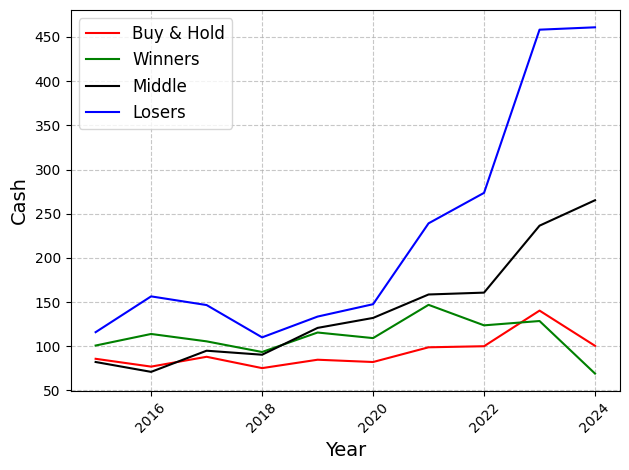

In [7]:
# Weekly Growth Curve
import matplotlib.pyplot as plt

years = range(2015, 2025)
plt.plot(years, df7['Value'], label='Buy & Hold', color='RED')
plt.plot(years, df6['Winners'], label='Winners',color="GREEN")
plt.plot(years, df6['Median'], label='Middle', color="BLACK")
plt.plot(years, df6['Losers'], label='Losers', color="BLUE") 

#plt.title('Cash Values Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cash', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

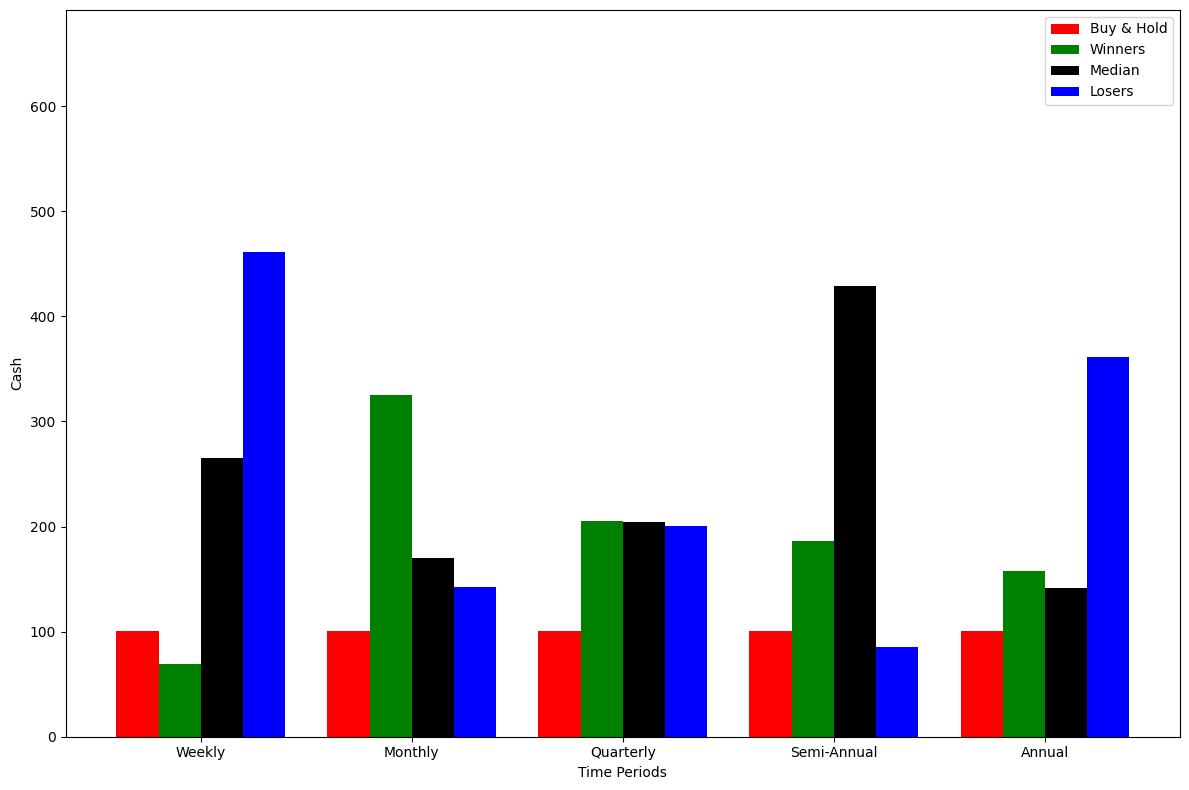

In [8]:
import matplotlib.pyplot as plt
import numpy as np


bh_values = [df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1]]
w_values = [df6["Winners"].iloc[-1],df5["Winners"].iloc[-1],df4["Winners"].iloc[-1],df3["Winners"].iloc[-1],df2["Winners"].iloc[-1]]
l_values = [df6["Losers"].iloc[-1],df5["Losers"].iloc[-1],df4["Losers"].iloc[-1],df3["Losers"].iloc[-1],df2["Losers"].iloc[-1]]
m_values = [df6["Median"].iloc[-1],df5["Median"].iloc[-1],df4["Median"].iloc[-1],df3["Median"].iloc[-1],df2["Median"].iloc[-1]]

categories = ["Weekly", 'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']

n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(12, 8))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')


plt.xlabel('Time Periods')
plt.ylabel('Cash')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()

def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

max_value = max(max(bh_values), max(w_values), max(l_values), max(m_values))
plt.ylim(0, max_value * 1.5) 

plt.tight_layout()
plt.show()


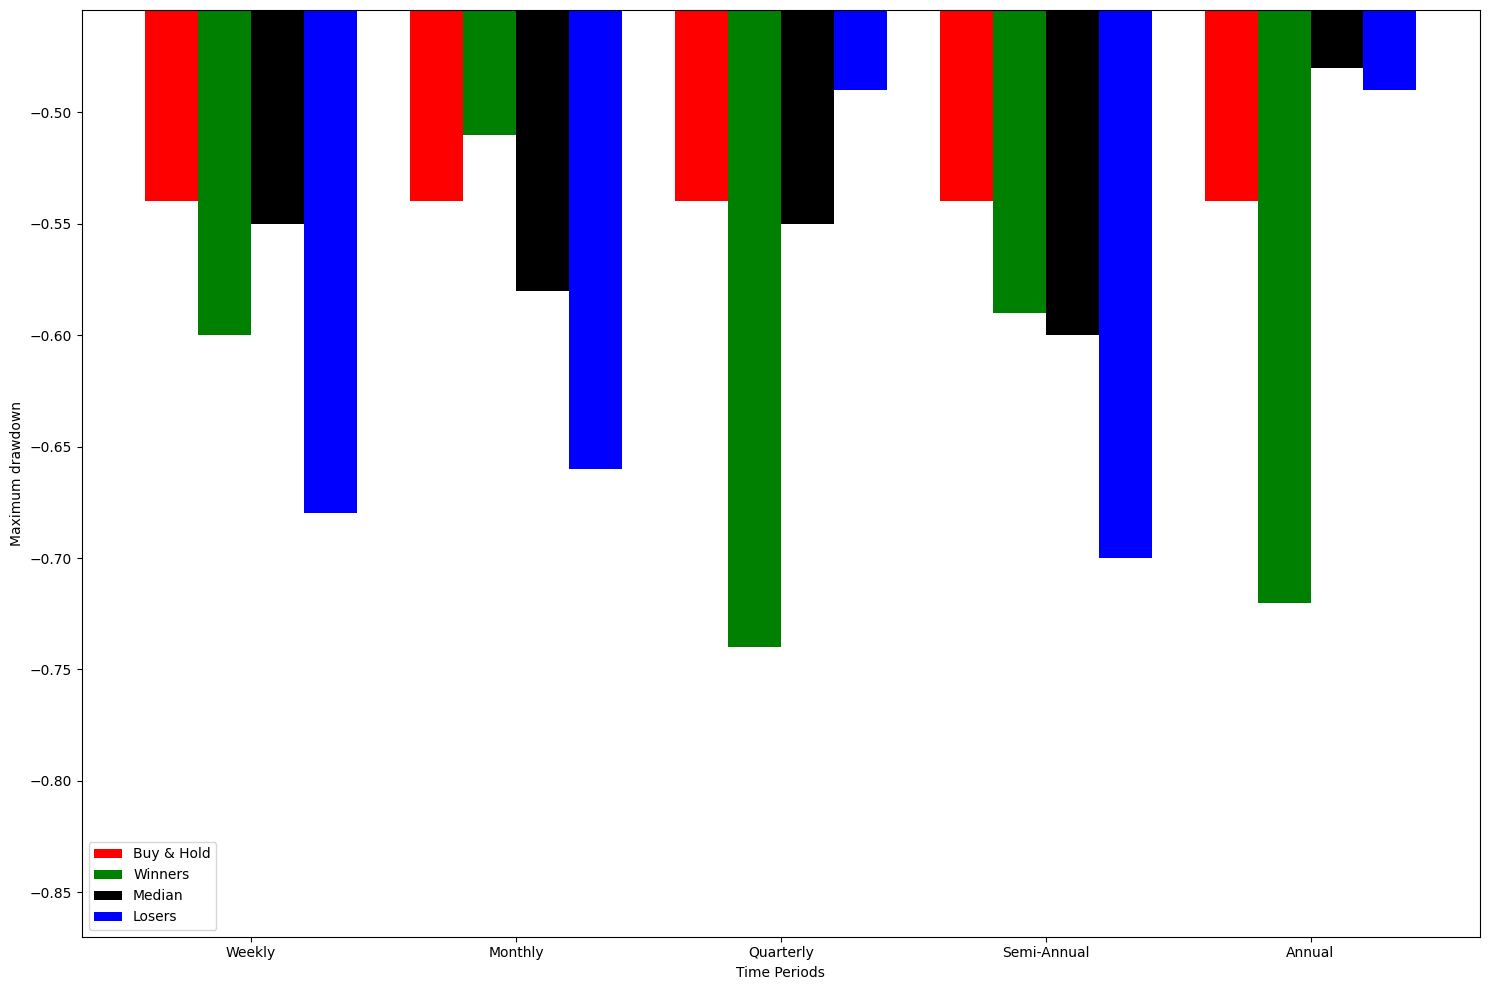

In [9]:
import matplotlib.pyplot as plt
import numpy as np

bh_values = [bh_week_maxdd,bh_mon_maxdd,bh_quar_maxdd,bh_sa_maxdd,bh_a_maxdd]
w_values = [w_week_maxdd,w_mon_maxdd,w_quar_maxdd,w_sa_maxdd,w_a_maxdd]
l_values = [l_week_maxdd,l_mon_maxdd,l_quar_maxdd,l_sa_maxdd,l_a_maxdd]
m_values = [m_week_maxdd,m_mon_maxdd,m_quar_maxdd,m_sa_maxdd,m_a_maxdd]

categories = ["Weekly",'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']


n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(15, 10))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')



plt.xlabel('Time Periods')
plt.ylabel('Maximum drawdown')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()


# Adjust y-scale to increase negative direction
y_min = min(min(bh_values), min(w_values), min(l_values), min(m_values))
y_max = max(max(bh_values), max(w_values), max(l_values), max(m_values))
y_range = y_max - y_min

# Extend the lower limit further into the negative
plt.ylim(y_min - 0.5 * y_range, y_max + 0.1 * y_range)



def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='top')

plt.tight_layout()
plt.show()

In [10]:
w_values

[-0.6, -0.51, -0.74, -0.59, -0.72]

In [11]:
m_values

[-0.55, -0.58, -0.55, -0.6, -0.48]

In [12]:
l_values

[-0.68, -0.66, -0.49, -0.7, -0.49]

In [13]:
bh_values

[-0.539842841680435,
 -0.539842841680435,
 -0.539842841680435,
 -0.539842841680435,
 -0.539842841680435]